In [2]:
%%html
<style>
    #notebook-container{
    width: 100%
    }
</style>

In [3]:
import numpy as np #importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as sm_stat
import math
import rpy2.robjects as robjects

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn import linear_model
from sklearn import model_selection
from scipy import stats
from sklearn.svm import SVR

sns.set()

In [4]:
# telco_df = pd.read_csv('telco.txt', sep='\t') #load dataset
telco_df = pd.read_csv('https://raw.githubusercontent.com/kai-wren/Statistic/master/telco.txt', sep='\t') #load dataset
telco_df.head()

,tenure,age,marital,address,income,ed,employ,retire,gender,longmon,wiremon,churn
1,13,44,Married,9,64,College degree,5,No,Male,3.70,0.0,Yes
2,11,33,Married,7,136,Post-undergraduate degree,5,No,Male,4.40,35.7,Yes
3,68,52,Married,24,116,Did not complete high school,29,No,Female,18.15,0.0,No
4,33,33,Unmarried,12,33,High school degree,0,No,Female,9.45,0.0,Yes
5,23,30,Married,9,30,Did not complete high school,2,No,Male,6.30,0.0,No


# Problem 6: Regression techniques

In this problem we use the same data set on service usage of 1000 clients of a telecommunication company as in Assignment 2. The variable "tenure" is taken as the dependent variable and the remaining variables as explanatory. <br>

## Subtask 1.

The lasso regression is an alternative approach to variable selection. <br>

### Part (a)
Explain in your own words the idea of the lasso regression. Sketch a situation when a simple linear regression fails, but the lasso regression still can be estimated.

### Part (b)

For the usual regression model the variables are rarely normalized/standardized. However, in the case of the lasso regression the scaling becomes crucial. Why? Scale your data by $(x_i - \bar x)/\hat \sigma_x$. Can/should the binary variables be scaled in the same fashion? How would you handle the variable "ed"?

For Lasso regression scaling of data become crucial because independent variables should be centered around 0 (have mean of 0). Because of this reason we perform scaling of data as per formula $\frac{(x_i - \bar x)}{\hat \sigma_x}$. Without scaling Lasso regression would provide a wrong results - countours of Least Square solution will intersect with non-scaled data in different points than it should. <br>

As for binary variables - those should be scaled as well. Otherwise for such variables like "gender" mean value will be around 0.5 and not 0 as it should be. Same holds for other binary variables - mean value is not equal to 0 as result Lasso regression will produce wrong results. Hence, I am also scaling all dummy variables to center those around mean of 0. <br>

For variable "ed", in addition to scaling, we also need to group all education related dummy variables and perform group Lasso regression which keeps related dummy variables as single group. In such case either none or all of such variables are excluded. Grouped dummy variables could not be excluded partially.

In [5]:
telco_df_norm = telco_df.copy() #normalizing data

telco_df_norm.tenure = (telco_df_norm.tenure-telco_df_norm.tenure.mean()) / telco_df_norm.tenure.std()
telco_df_norm.age = (telco_df_norm.age-telco_df_norm.age.mean()) / telco_df_norm.age.std()
telco_df_norm.address = (telco_df_norm.address-telco_df_norm.address.mean()) / telco_df_norm.address.std()
telco_df_norm.income = (telco_df_norm.income-telco_df_norm.income.mean()) / telco_df_norm.income.std()
telco_df_norm.employ = (telco_df_norm.employ-telco_df_norm.employ.mean()) / telco_df_norm.employ.std()
telco_df_norm.longmon = (telco_df_norm.longmon-telco_df_norm.longmon.mean()) / telco_df_norm.longmon.std()
telco_df_norm.wiremon = (telco_df_norm.wiremon-telco_df_norm.wiremon.mean()) / telco_df_norm.wiremon.std()

telco_df_norm.describe()

,tenure,age,address,income,employ,longmon,wiremon
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00


In [6]:
telco_df_norm_dummy = telco_df_norm.copy()

telco_df_norm_dummy = pd.get_dummies(telco_df_norm, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_norm_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_norm_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_norm_dummy.marital_dummy = (telco_df_norm_dummy.marital_dummy-telco_df_norm_dummy.marital_dummy.mean()) / telco_df_norm_dummy.marital_dummy.std()
telco_df_norm_dummy.retire_dummy = (telco_df_norm_dummy.retire_dummy-telco_df_norm_dummy.retire_dummy.mean()) / telco_df_norm_dummy.retire_dummy.std()
telco_df_norm_dummy.gender_dummy = (telco_df_norm_dummy.gender_dummy-telco_df_norm_dummy.gender_dummy.mean()) / telco_df_norm_dummy.gender_dummy.std()
telco_df_norm_dummy.churn_dummy = (telco_df_norm_dummy.churn_dummy-telco_df_norm_dummy.churn_dummy.mean()) / telco_df_norm_dummy.churn_dummy.std()
telco_df_norm_dummy.ed_dummy_college_degree = (telco_df_norm_dummy.ed_dummy_college_degree-telco_df_norm_dummy.ed_dummy_college_degree.mean()) / telco_df_norm_dummy.ed_dummy_college_degree.std()
telco_df_norm_dummy.ed_dummy_no_high_school = (telco_df_norm_dummy.ed_dummy_no_high_school-telco_df_norm_dummy.ed_dummy_no_high_school.mean()) / telco_df_norm_dummy.ed_dummy_no_high_school.std()
telco_df_norm_dummy.ed_dummy_high_school = (telco_df_norm_dummy.ed_dummy_high_school-telco_df_norm_dummy.ed_dummy_high_school.mean()) / telco_df_norm_dummy.ed_dummy_high_school.std()
telco_df_norm_dummy.ed_dummy_some_college = (telco_df_norm_dummy.ed_dummy_some_college-telco_df_norm_dummy.ed_dummy_some_college.mean()) / telco_df_norm_dummy.ed_dummy_some_college.std()

telco_df_norm_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-1.503242e-16,2.208789e-16,-3.130829e-17,1.431633e-16,-1.676437e-17,-1.427414e-15,3.501643e-16,9.992007e-17,-1.318390e-16,-2.435829e-16,6.616929e-17,-8.992806e-17,-1.403322e-16,1.296740e-16,1.183498e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.616400e+00,-1.885847e+00,-1.145173e+00,-6.402498e-01,-1.089755e+00,-1.044349e+00,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
25%,-8.673297e-01,-7.710918e-01,-8.477516e-01,-4.534110e-01,-7.921971e-01,-6.294310e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
50%,-7.144258e-02,-1.340891e-01,-2.529078e-01,-2.852561e-01,-2.962680e-01,-3.085931e-01,-5.874360e-01,-9.895544e-01,-2.219654e-01,-9.660754e-01,-6.140302e-01,-5.524288e-01,-5.059893e-01,-6.341309e-01,-5.137687e-01
75%,8.648953e-01,7.417897e-01,6.393580e-01,5.105369e-02,5.964043e-01,2.595073e-01,6.657699e-01,1.009545e+00,-2.219654e-01,1.034081e+00,1.626956e+00,-5.524288e-01,-5.059893e-01,1.575384e+00,-5.137687e-01
max,1.707599e+00,2.812048e+00,4.307561e+00,1.485803e+01,3.571979e+00,8.513245e+00,5.089707e+00,1.009545e+00,4.500702e+00,1.034081e+00,1.626956e+00,1.808378e+00,1.974350e+00,1.575384e+00,1.944455e+00


### Part (c)

Run a lasso regression for data with $\lambda \in (0, 1)$. Plot the estimated parameters as functions of $\lambda$. Which value of $\lambda$ would you recommend? If it is easy to implement, then determine the optimal $\lambda$ by cross-validation.

For alpha=0.80000
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79900
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79800
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79700
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79600
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79500
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79400
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79300
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79200
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79100
Training score: 0.00000
Test score: -0.02047
Number of features used: 0 

For alpha=0.79000
Training score: 0.00000
Test score: -0.02047
Number of feature

For alpha=0.70300
Training score: 0.04696
Test score: 0.02166
Number of features used: 1 

For alpha=0.70200
Training score: 0.04824
Test score: 0.02282
Number of features used: 1 

For alpha=0.70100
Training score: 0.04953
Test score: 0.02398
Number of features used: 1 

For alpha=0.70000
Training score: 0.05081
Test score: 0.02514
Number of features used: 1 

For alpha=0.69900
Training score: 0.05209
Test score: 0.02629
Number of features used: 1 

For alpha=0.69800
Training score: 0.05337
Test score: 0.02745
Number of features used: 1 

For alpha=0.69700
Training score: 0.05465
Test score: 0.02860
Number of features used: 1 

For alpha=0.69600
Training score: 0.05592
Test score: 0.02976
Number of features used: 1 

For alpha=0.69500
Training score: 0.05719
Test score: 0.03091
Number of features used: 1 

For alpha=0.69400
Training score: 0.05847
Test score: 0.03206
Number of features used: 1 

For alpha=0.69300
Training score: 0.05974
Test score: 0.03321
Number of features used: 1 


For alpha=0.60400
Training score: 0.16539
Test score: 0.13027
Number of features used: 1 

For alpha=0.60300
Training score: 0.16649
Test score: 0.13130
Number of features used: 1 

For alpha=0.60200
Training score: 0.16760
Test score: 0.13234
Number of features used: 1 

For alpha=0.60100
Training score: 0.16870
Test score: 0.13337
Number of features used: 1 

For alpha=0.60000
Training score: 0.16980
Test score: 0.13439
Number of features used: 1 

For alpha=0.59900
Training score: 0.17089
Test score: 0.13542
Number of features used: 1 

For alpha=0.59800
Training score: 0.17199
Test score: 0.13645
Number of features used: 1 

For alpha=0.59700
Training score: 0.17308
Test score: 0.13747
Number of features used: 1 

For alpha=0.59600
Training score: 0.17417
Test score: 0.13850
Number of features used: 1 

For alpha=0.59500
Training score: 0.17526
Test score: 0.13952
Number of features used: 1 

For alpha=0.59400
Training score: 0.17635
Test score: 0.14054
Number of features used: 1 


For alpha=0.49500
Training score: 0.27503
Test score: 0.23523
Number of features used: 1 

For alpha=0.49400
Training score: 0.27593
Test score: 0.23612
Number of features used: 1 

For alpha=0.49300
Training score: 0.27684
Test score: 0.23701
Number of features used: 1 

For alpha=0.49200
Training score: 0.27774
Test score: 0.23790
Number of features used: 1 

For alpha=0.49100
Training score: 0.27864
Test score: 0.23879
Number of features used: 1 

For alpha=0.49000
Training score: 0.27954
Test score: 0.23968
Number of features used: 1 

For alpha=0.48900
Training score: 0.28043
Test score: 0.24056
Number of features used: 1 

For alpha=0.48800
Training score: 0.28133
Test score: 0.24144
Number of features used: 1 

For alpha=0.48700
Training score: 0.28222
Test score: 0.24233
Number of features used: 1 

For alpha=0.48600
Training score: 0.28311
Test score: 0.24321
Number of features used: 1 

For alpha=0.48500
Training score: 0.28400
Test score: 0.24409
Number of features used: 1 


For alpha=0.38100
Training score: 0.36643
Test score: 0.32860
Number of features used: 1 

For alpha=0.38000
Training score: 0.36713
Test score: 0.32935
Number of features used: 1 

For alpha=0.37900
Training score: 0.36782
Test score: 0.33009
Number of features used: 1 

For alpha=0.37800
Training score: 0.36852
Test score: 0.33083
Number of features used: 1 

For alpha=0.37700
Training score: 0.36921
Test score: 0.33157
Number of features used: 1 

For alpha=0.37600
Training score: 0.36990
Test score: 0.33231
Number of features used: 1 

For alpha=0.37500
Training score: 0.37058
Test score: 0.33305
Number of features used: 1 

For alpha=0.37400
Training score: 0.37127
Test score: 0.33379
Number of features used: 1 

For alpha=0.37300
Training score: 0.37195
Test score: 0.33453
Number of features used: 1 

For alpha=0.37200
Training score: 0.37263
Test score: 0.33526
Number of features used: 1 

For alpha=0.37100
Training score: 0.37331
Test score: 0.33599
Number of features used: 1 


For alpha=0.27300
Training score: 0.46203
Test score: 0.42984
Number of features used: 4 

For alpha=0.27200
Training score: 0.46285
Test score: 0.43073
Number of features used: 4 

For alpha=0.27100
Training score: 0.46366
Test score: 0.43162
Number of features used: 4 

For alpha=0.27000
Training score: 0.46447
Test score: 0.43251
Number of features used: 4 

For alpha=0.26900
Training score: 0.46527
Test score: 0.43339
Number of features used: 4 

For alpha=0.26800
Training score: 0.46608
Test score: 0.43427
Number of features used: 4 

For alpha=0.26700
Training score: 0.46687
Test score: 0.43515
Number of features used: 4 

For alpha=0.26600
Training score: 0.46767
Test score: 0.43603
Number of features used: 4 

For alpha=0.26500
Training score: 0.46846
Test score: 0.43690
Number of features used: 4 

For alpha=0.26400
Training score: 0.46926
Test score: 0.43777
Number of features used: 4 

For alpha=0.26300
Training score: 0.47004
Test score: 0.43864
Number of features used: 4 


Test score: 0.52019
Number of features used: 5 

For alpha=0.15900
Training score: 0.53829
Test score: 0.52109
Number of features used: 5 

For alpha=0.15800
Training score: 0.53891
Test score: 0.52199
Number of features used: 5 

For alpha=0.15700
Training score: 0.53952
Test score: 0.52288
Number of features used: 5 

For alpha=0.15600
Training score: 0.54012
Test score: 0.52377
Number of features used: 5 

For alpha=0.15500
Training score: 0.54072
Test score: 0.52466
Number of features used: 5 

For alpha=0.15400
Training score: 0.54132
Test score: 0.52554
Number of features used: 5 

For alpha=0.15300
Training score: 0.54192
Test score: 0.52642
Number of features used: 5 

For alpha=0.15200
Training score: 0.54250
Test score: 0.52730
Number of features used: 5 

For alpha=0.15100
Training score: 0.54309
Test score: 0.52817
Number of features used: 5 

For alpha=0.15000
Training score: 0.54367
Test score: 0.52904
Number of features used: 5 

For alpha=0.14900
Training score: 0.54425

For alpha=0.05000
Training score: 0.60170
Test score: 0.60129
Number of features used: 8 

For alpha=0.04900
Training score: 0.60230
Test score: 0.60183
Number of features used: 8 

For alpha=0.04800
Training score: 0.60289
Test score: 0.60236
Number of features used: 8 

For alpha=0.04700
Training score: 0.60347
Test score: 0.60288
Number of features used: 8 

For alpha=0.04600
Training score: 0.60403
Test score: 0.60339
Number of features used: 8 

For alpha=0.04500
Training score: 0.60458
Test score: 0.60389
Number of features used: 8 

For alpha=0.04400
Training score: 0.60512
Test score: 0.60438
Number of features used: 8 

For alpha=0.04300
Training score: 0.60565
Test score: 0.60485
Number of features used: 8 

For alpha=0.04200
Training score: 0.60617
Test score: 0.60531
Number of features used: 8 

For alpha=0.04100
Training score: 0.60667
Test score: 0.60576
Number of features used: 8 

For alpha=0.04000
Training score: 0.60716
Test score: 0.60620
Number of features used: 8 


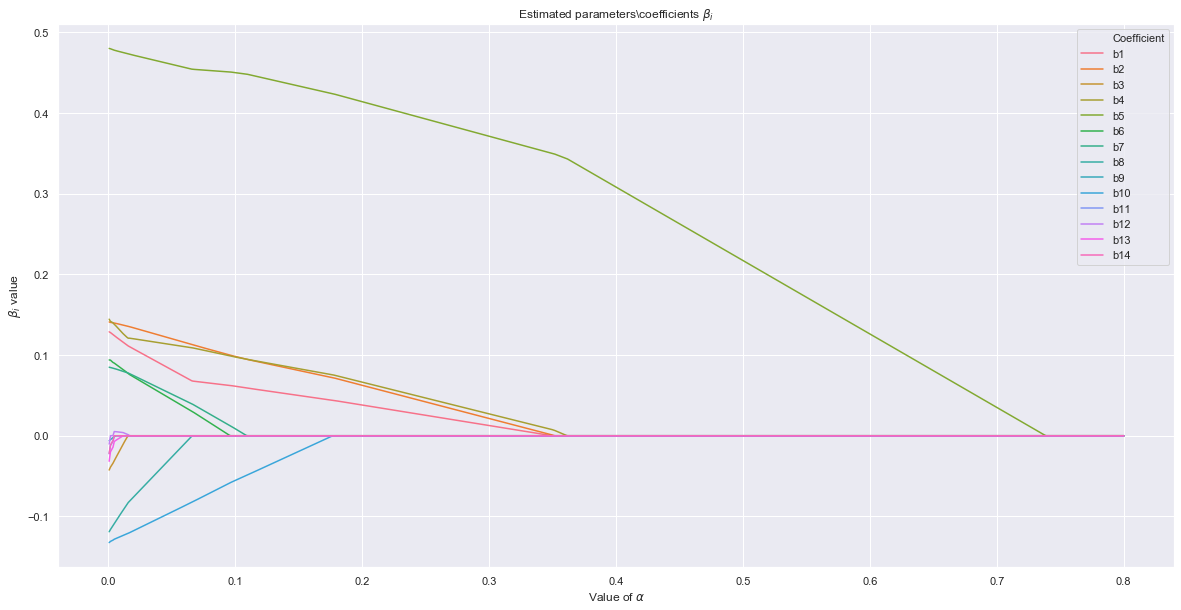

In [7]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

# lambdas = [0.9, 0.5, 0.25, 0.1, 0.01, 0.001, 0.0001]
lambdas = np.arange(0.8, 0, -0.001)
coefficients = []

for lambd in lambdas:
    X_train,X_test,Y_train,Y_test=model_selection.train_test_split(X,Y, test_size=0.3, random_state=7)

    lasso = linear_model.Lasso(alpha=lambd)
    lasso.fit(X_train,Y_train)
    train_score=lasso.score(X_train,Y_train)
    test_score=lasso.score(X_test,Y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    coefficients.append(lasso.coef_)

    print("For alpha=%.5f" %lambd)
    print("Training score: %.5f" %train_score )
    print("Test score: %.5f" %test_score)
    print("Number of features used: %s \n" %coeff_used)
    

coefficients_df = pd.DataFrame(coefficients, columns=["b1", "b2", "b3", "b4", "b5", "b6", "b7", "b8", "b9", "b10", "b11", "b12", "b13", "b14"])
coefficients_df['alpha'] = lambdas
coefficients_df = coefficients_df.melt(id_vars=['alpha'], var_name='Coefficient')
coefficients_df.tail()

plt.figure(figsize=(20,10))
ax = sns.lineplot(x="alpha", y="value", hue="Coefficient", data=coefficients_df, )
# sns.lineplot(x=alphas, y="b2", data=coefficients_df)
# sns.lineplot(x=alphas, y="b3", data=coefficients_df)
plt.title("Estimated parameters\coefficients $\\beta_i$")
plt.ylabel("$\\beta_i$ value")
plt.xlabel("Value of $\\alpha$")
plt.show()

From this plot and printed test errors we could see that more or less accuracy of 61% achieved around $\lambda = 0.03$ so it make sense to recommend this value. Also with this values of $\lambda$ there is only 8 non-zero features coefficients and others are zeroed out. Now I would try to find optimal values of $\lambda$ by cross-validation.

In [8]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])
Y = telco_df_norm_dummy.copy().tenure

lassoCV = linear_model.LassoCV(cv=15, random_state=7)
lassoCV.fit(X, Y)

print("Final score of CV: %.5f" %lassoCV.score(X, Y))
print("Optimal value of found by CV lambda = %.5f" %lassoCV.alpha_)
print("Optimal coefficients found by CV: %s" %lassoCV.coef_.round(5))

Final score of CV: 0.62021
Optimal value of found by CV lambda = 0.01162
Optimal coefficients found by CV: [ 0.09673  0.1427  -0.       0.11734  0.51164  0.05954  0.06464 -0.08162
 -0.0027  -0.1452  -0.00884  0.      -0.      -0.     ]


Optimal value of $\lambda$ found by Cross Validation is $\lambda=0.01162$.

## Subtask 2.

A nonlinear regression oﬀers a ﬂexible technique for modelling complex relationships. We wish to explain the "tenure" by the long distance calls per month "longmon". <br>

### Part (a)

Make a bivariate scatter plot and estimate an appropriate linear model. Add the regression line to the plot. 

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


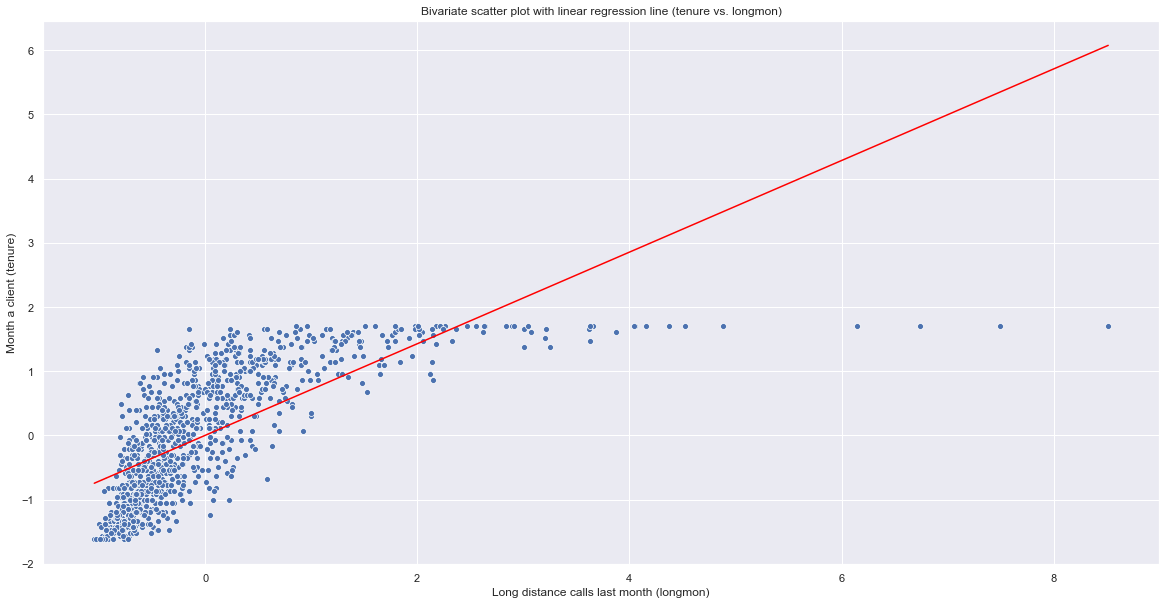

Adjusted R2 score of linear model: 0.50884
Root Mean Square Error (RMSE) of linear model: 0.70012


In [9]:
X = telco_df_norm_dummy.copy().longmon
X = sm.add_constant(X)
Y = telco_df_norm_dummy.copy().tenure

result = sm.OLS(Y , X).fit()

Y_pred_man = np.dot(X, result.params)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=Y_pred_man, color='red')
plt.title("Bivariate scatter plot with linear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - result.fittedvalues)**2).mean())
print("Adjusted R2 score of linear model: %.5f" %result.rsquared_adj)
print("Root Mean Square Error (RMSE) of linear model: %.5f" %rmse)

# result.summary()

### Part(b)

Estimate now an appropriate nonlinear regression which might ﬁt the data better. Add the regression curve to the plot and compare (quantitatively) the ﬁt with the ﬁt of the linear model. 

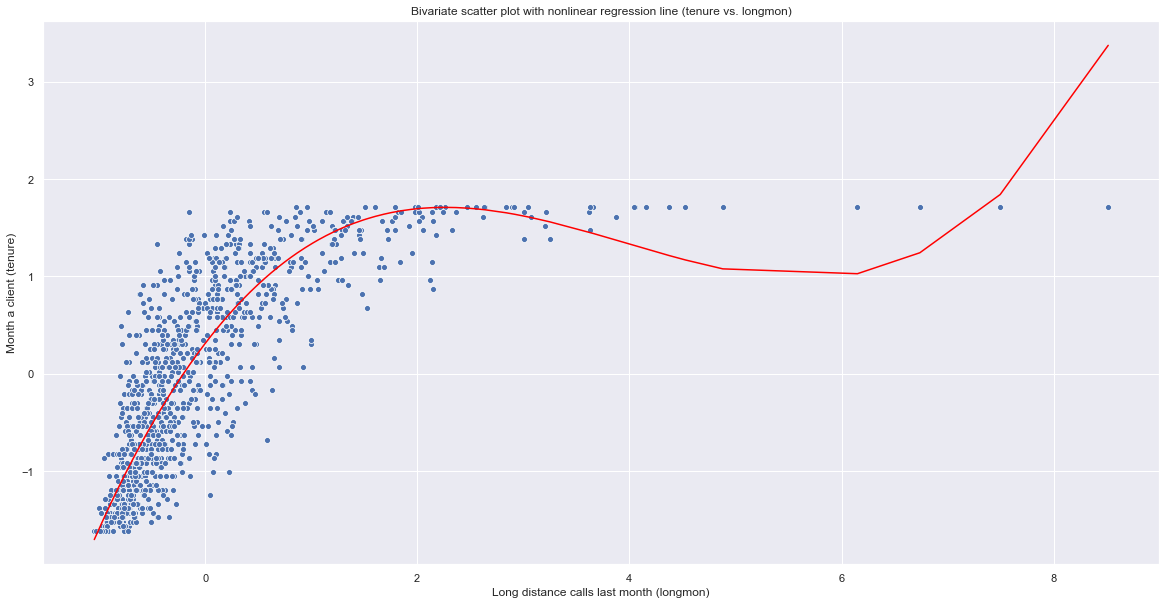

R2 score of nonlinear model: 0.71297
Root Mean Square Error (RMSE) of nonlinear model: 0.53548


In [10]:
X = telco_df_norm_dummy.copy().longmon
X = X.to_numpy().reshape(-1, 1)
Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
model.fit(X,Y)

plt.figure(figsize=(20,10))
sns.scatterplot(x=X.reshape(-1), y=telco_df_norm_dummy.tenure)
sns.lineplot(x=X.reshape(-1), y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean())
print("R2 score of nonlinear model: %.5f" %model.score(X,Y))
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

To compare linear regression fit with nonlinear one numerically we could use Root Mean Square Error (RMSE) value of both models. I have calcualted it for each model by subtracting predicted value from real one, then square difference, calculate mean of all squared deviations and take square root from mean in the end. Since RMSE of linear model is 0.70012 and RMSE of nonlinear model is 0.53548 we could conclude that non-linear model fits given data better.

### Part (c)

Explain in your own words, why all the classical tests and inferences are not directly applicable to the NLS estimators.

Classical test and inferences assume normal distribution of observations (or errors). However, in case of NLS estimators distribution of model errors is not normal one. Hence those tests and inferences are not directly applicable to NLS estimators. Resulting $\hat \beta$ is not a linear function of residuals $u_k$, because of this $\hat \beta$ has non-linear distribution. But still Maximum Likelihood (ML) estimators are consistent and efficient for NLS because they have smallest variance among all estimators (best of what we can get). All tests and inferences valid only asymptotically.

### Part (d)

What kind of problems might arise if we decide to ﬁt a non-linear regression using all explanatory variables?

In case if we will decide to fit nonlinear regression using all explanatory variables we will end up with very complex nonlinear function. Below I have visualize same plot as above, but model was fitted to all variables and not only to "longmon". As you could see - function is extremly complex in such case. It is impossible to find manually such complex function. Another issue - function is definetly overfitted with regards to training data. Most probably such model will behave badly on unseen (test) data. Also, such higly nonlinear systems could be solved only numerically - no exact solution exist.

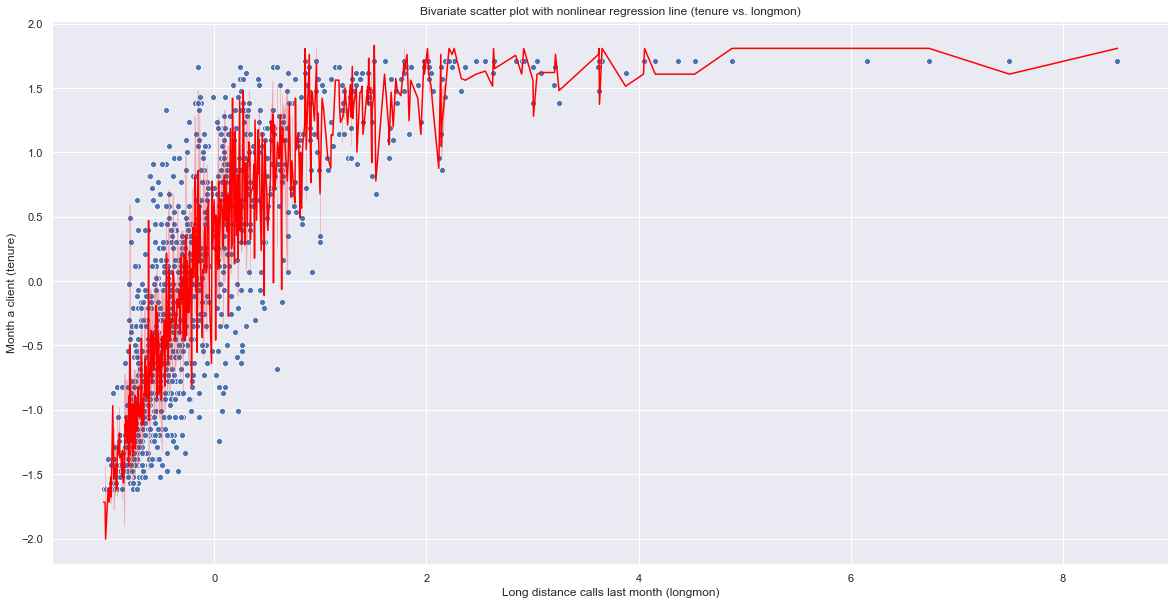

R2 score of nonlinear model: 0.84106
Root Mean Square Error (RMSE) of nonlinear model: 0.39847


In [11]:
X = telco_df_norm_dummy.copy().drop(columns=['tenure'])

Y = telco_df_norm_dummy.copy().tenure

model = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)
model.fit(X,Y)

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=model.predict(X), color='red')
plt.title("Bivariate scatter plot with nonlinear regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - model.predict(X))**2).mean())
print("R2 score of nonlinear model: %.5f" %model.score(X,Y))
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

## Subtask 3.

Next we model the relationship between "tenure" and "longmon" using the nonparametric Nadaraya-Watson regression.

### Part (a)

An important calibration parameter of a nonparametric regression is the bandwidth. Explain what happens with the regression/the weights in the Nadaraya-Watson regression if the bandwidth is too high or too small.

All Kernel Density Estimators heavily depends on bandwith $h$ and Nadaraya-Watson regression is not an exclusion here. Kernels are window functions width of which are set by bandwith parameter. So with $h \rightarrow \inf$ kernel will include all points with equal weights and regression will look like linear regression. On opposite, if $h$ is small - then model will fit values locally, means it will fit mean to each point individually. So bandwith $h$ determines how local kernel density estimator with regards to points $X_i$.

### Part (b)

Fit a Nadaraya-Watson regression with Gaussian kernel and “optimal” bandwidth to the "longmon"/"tenure" data. Check and explain how the “optimal bandwidth” is determined in your software. Compare the (in-sample) ﬁt of the nonparametric regression and the nonlinear regression in the previous subproblem.

C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\nonparametric\kernel_regression.py:251: RuntimeWarning: invalid value encountered in true_divide
  B_x = (G_numer * d_fx - G_denom * d_mx) / (G_denom**2)


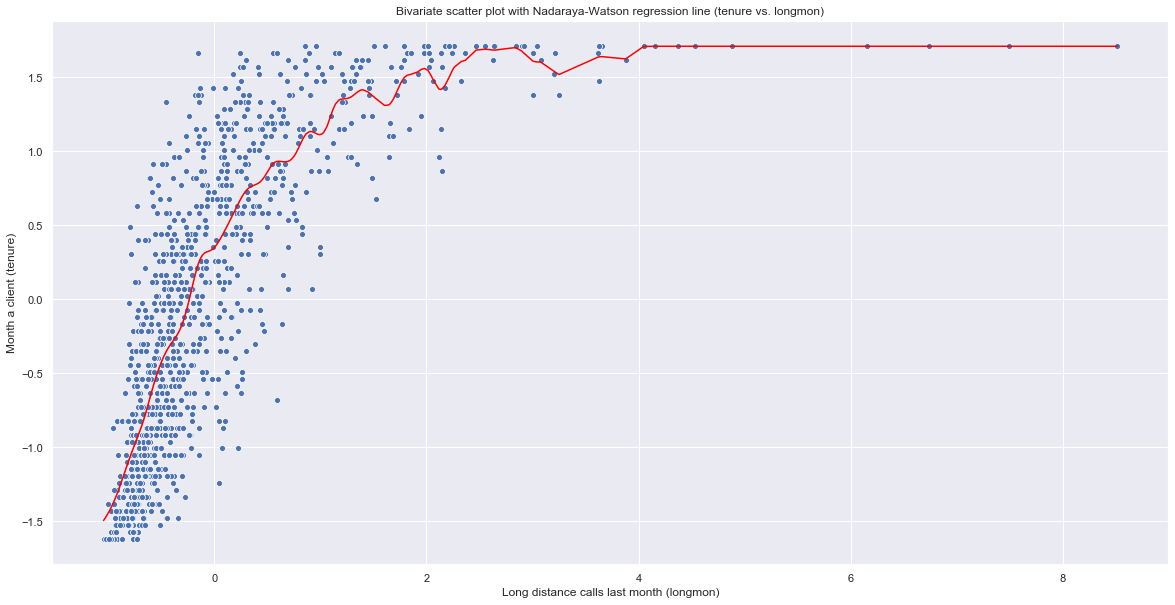

R2 score of Nadaraya-Watson model: 0.72775
Root Mean Square Error (RMSE) of nonlinear model: 0.52171


In [12]:
from statsmodels.nonparametric.kernel_regression import KernelReg

X = telco_df_norm_dummy.copy().longmon
Y = telco_df_norm_dummy.copy().tenure

NWmodel = KernelReg(endog=Y, exog=X, var_type='c', ckertype='gaussian', reg_type='lc', bw='cv_ls')

plt.figure(figsize=(20,10))
sns.scatterplot(x=telco_df_norm_dummy.longmon, y=telco_df_norm_dummy.tenure)
sns.lineplot(x=telco_df_norm_dummy.longmon, y=NWmodel.fit(X)[0], color='red')
plt.title("Bivariate scatter plot with Nadaraya-Watson regression line (tenure vs. longmon)")
plt.ylabel("Month a client (tenure)")
plt.xlabel("Long distance calls last month (longmon)")
plt.show()

rmse = np.sqrt(((Y - NWmodel.fit(X)[0])**2).mean())
print("R2 score of Nadaraya-Watson model: %.5f" %NWmodel.r_squared())
print("Root Mean Square Error (RMSE) of nonlinear model: %.5f" %rmse)

I've used Least Square Cross Validation (LSCV) method for optimal bandwith selection. Idea behind this method is to compare target value with leave-one-out estimator on each step to recieve least squares cross-validation error. Then final optimal bandwith value will be such value of bandwith for which least squares cross-validation error reach it global minimum value.

Comparing $R^2$ score and RMSE of Nadaraya-Watson (NW) model with nonlinear model we could see that NW model is sligntly better - it has higher $R^2$ score and lower RMSE. But difference itself is minor one. Hence, I could conclude that in this particular case nonlinear regression and nonparametric NW regression leads to simillar results.

## Subtask 4.

Next we consider classiﬁcation of the clients using the "churn" variable as the dependent variable and the logistic regression.

### Part (a)

Fit a logistic regression to explain "churn" by the remaining explanatory variables. 

In [13]:
telco_df_dummy = telco_df.copy()

telco_df_dummy = pd.get_dummies(telco_df_dummy, columns=(['marital', 'retire', 'gender', 'churn', 'ed']))

telco_df_dummy.drop(columns=(['marital_Unmarried', 'retire_No', 'gender_Female', 'churn_No', 
                                               'ed_Post-undergraduate degree']), inplace=True)
telco_df_dummy.rename(columns={'marital_Married': 'marital_dummy', 'retire_Yes': 'retire_dummy', 
                               'gender_Male': 'gender_dummy', 'churn_Yes': 'churn_dummy', 
                              'ed_College degree': 'ed_dummy_college_degree', 
                               'ed_Did not complete high school': 'ed_dummy_no_high_school',
                              'ed_High school degree': 'ed_dummy_high_school',
                              'ed_Some college': 'ed_dummy_some_college'}, inplace=True)

telco_df_dummy.describe()

,tenure,age,address,income,employ,longmon,wiremon,marital_dummy,retire_dummy,gender_dummy,churn_dummy,ed_dummy_college_degree,ed_dummy_no_high_school,ed_dummy_high_school,ed_dummy_some_college
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.526000,41.684000,11.551000,77.535000,10.987000,11.723100,11.583900,0.495000,0.047000,0.483000,0.274000,0.234000,0.204000,0.287000,0.209000
std,21.359812,12.558816,10.086681,107.044165,10.082087,10.363486,19.719426,0.500225,0.211745,0.499961,0.446232,0.423584,0.403171,0.452588,0.406798
min,1.000000,18.000000,0.000000,9.000000,0.000000,0.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,32.000000,3.000000,29.000000,3.000000,5.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,34.000000,40.000000,9.000000,47.000000,8.000000,8.525000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54.000000,51.000000,18.000000,83.000000,17.000000,14.412500,24.712500,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,72.000000,77.000000,55.000000,1668.000000,47.000000,99.950000,111.950000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
Y = telco_df.copy().churn
Y = pd.get_dummies(Y, columns=(['churn']))

X = telco_df_norm_dummy.copy().drop(columns=['churn_dummy'])
Y = Y.Yes

# X = telco_df_dummy.copy().drop(columns=['churn_dummy'])
# Y = telco_df_dummy.copy().churn_dummy

X = sm.add_constant(X)
log_model = sm.Logit(endog=Y, exog=X, missing='raise').fit()

log_model.summary2()

log_model.loglike()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AttributeError: 'LogitResults' object has no attribute 'loglike'

### Part (b)

Consider the explanatory variable "tenure". Obviously its parameter cannot be interpreted in the same way as for a linear regression. Provide the correct interpretation using the parameter and using odds. 

In [15]:
print("Explanatory variable: %s" %X.columns[1])
print("Coefficient of %s" %X.columns[1], "is %.5f" %log_model.params[1])
print("Odds of %s" %X.columns[1], "is %.5f" %np.exp(log_model.params[1]))

Explanatory variable: tenure
Coefficient of tenure is -0.67691
Odds of tenure is 0.50819


From negative coefficient of "tenure" we coud see that increase of "tenure" value descrease probability of churn. Such behavior make sense because longer you stay as a client, less probability you will terminate the contract. If we consider odds ratio of "tenure", we could see that increase of "tenure" value by 1 month decrease odds of contract termination by half approximately (odds ration = 0.50819).

### Part (c)

Run a stepwise model selection using AIC as criterion. Further consider only the optimal model chosen here. From the ﬁnal model, which of the variables do increase the probability of churn and which variables decrease this probability? Is this consistent with economic intuition?

In [24]:
from rpy2.robjects.packages import importr
lazyeval = importr("lazyeval")
from rpy2.robjects.lib.dplyr import DataFrame

r_glm = robjects.r["glm"]


# telco <- read.csv(url('https://drive.google.com/uc?export=download&id=1j1lfJLVIaGag1q5jl7ktO8zShXrGTQgx'))
# logit.model <- suppressWarnings(glm(churn ~ ., family=binomial('logit'), data=telco))
# optimal.logit.model <- suppressWarnings(step(logit.model, direction = "both"))
# summary(optimal.logit.model)

RRuntimeError: Error in loadNamespace(name) : there is no package called 'lazyeval'


In [16]:
def find_best_model_forward(model, Y, full_model): #defining recursive method of step-wise backwards model selection using AIC as criteria
    print(model.columns)
    if model.size != 0:
        X = model.copy() #performing simple regression for big model
        X = sm.add_constant(X)
        res = sm.Logit(Y , X).fit()
        X = X.drop('const', axis=1)
        min_aic = res.aic #setting minimal AIC and model values
    else:
        min_aic=math.inf
        
    is_better_model = False #setting flag to decide when to exit recursion
    X = full_model.copy()
    
    for col in X.columns: #looping over columns of model and drop columns one-by-one
        Xi = model.copy()
        Xi[col] = X.copy()[col]
        Xi = sm.add_constant(Xi)
        print(Xi.columns)
        res_i = sm.Logit(Y, Xi).fit()
        print(res_i.aic, min_aic, col)
        if res_i.aic < min_aic: #compare AIC of model with one less column with bigger one AIC
            is_better_model = True #if more optimal model found, reassign minimal AIC and model values
            min_aic = res_i.aic
            min_model = model.copy()
            min_model[col] = X.copy()[col]
            max_model = full_model.copy().drop(col, axis=1)
    
    if is_better_model == True: #if there is a smaller model, call same method again to look for even better one
        min_aic, min_model = find_best_model_forward(min_model, Y, max_model)
        
    return min_aic, min_model #return minimal model and AIC values
            

# big_model = telco_df_norm_dummy.copy().drop('churn_dummy', axis=1) #setting full model
big_model = telco_df_dummy.copy().drop('churn_dummy', axis=1)
# Y = pd.get_dummies(telco_df.copy().churn, columns=(['churn']))
empty_model = pd.DataFrame()

aic, best_model = find_best_model_forward(empty_model, telco_df_dummy.copy().churn_dummy, big_model) #call method to find optimal model

print("Smallest achieved AIC=%.5f \n" %aic) #printing results
print("Optimal model contains %s columns:" %best_model.columns.size)
for col in best_model.columns:
    print(col)

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Admin\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Index([], dtype='object')
Index(['const', 'tenure'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf inf tenure
Index(['const', 'age'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf inf age
Index(['const', 'address'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf inf address
Index(['const', 'income'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf inf income
Index(['const', 'employ'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf inf employ
Index(['const', 'longmon'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
inf inf longmon
Index(['const', 'wiremon'], dtype='object')
Op

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is dep

Optimization terminated successfully.
         Current function value: inf
         Iterations 6
inf 361536.64056780614 employ
Index(['const', 'gender_dummy', 'longmon'], dtype='object')
Optimization terminated successfully.
         Current function value: inf
         Iterations 7
inf 361536.64056780614 longmon
Index(['const', 'gender_dummy', 'wiremon'], dtype='object')
Optimization terminated successfully.
         Current function value: 184.887984
         Iterations 5
369781.96711567556 361536.64056780614 wiremon
Index(['const', 'gender_dummy', 'marital_dummy'], dtype='object')
Optimization terminated successfully.
         Current function value: 181.466211
         Iterations 5
362938.4215262463 361536.64056780614 marital_dummy
Index(['const', 'gender_dummy', 'retire_dummy'], dtype='object')
Optimization terminated successfully.
         Current function value: 191.049120
         Iterations 7
382104.2400294392 361536.64056780614 retire_dummy
Index(['const', 'gender_dummy', 'ed

C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\Admin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is dep

UnboundLocalError: local variable 'min_model' referenced before assignment

In [ ]:
def find_best_model(model, Y): #defining recursive method of step-wise backwards model selection using AIC as criteria
    X = model.drop('churn_dummy', axis=1).copy() #performing simple regression for big model
    X = sm.add_constant(X)
    res = sm.Logit(Y , X).fit()
    X = X.drop('const', axis=1)
    
    min_aic = res.aic #setting minimal AIC and model values
    min_model = model.copy()
    is_better_model = False #setting flag to decide when to exit recursion
    
    for col in X.columns: #looping over columns of model and drop columns one-by-one
        Xi = X.drop(col, axis=1).copy()
        Xi = sm.add_constant(Xi)
        res_i = sm.Logit(Y, Xi).fit()
        if res_i.aic < min_aic: #compare AIC of model with one less column with bigger one AIC
            is_better_model = True #if more optimal model found, reassign minimal AIC and model values
            min_aic = res_i.aic
            min_model = model.drop(col, axis=1).copy()
    
    if is_better_model == True: #if there is a smaller model, call same method again to look for even better one
        min_aic, min_model = find_best_model(min_model, Y)
        
    return min_aic, min_model #return minimal model and AIC values
            

big_model = telco_df_norm_dummy.copy() #setting full model
Y = pd.get_dummies(telco_df.copy().churn, columns=(['churn']))

aic, best_model = find_best_model(big_model, Y.Yes) #call method to find optimal model

print("Smallest achieved AIC=%.5f \n" %aic) #printing results
print("Optimal model contains %s columns:" %best_model.columns.size)
for col in best_model.columns:
    print(col)